In [1]:
from copy import deepcopy, copy
import os
import pathlib
from random import shuffle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset, WeightedRandomSampler
from livelossplot import PlotLosses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from chord_recognition.augmentations import SemitoneShift, DetuningShift
from chord_recognition.cache import HDF5Cache
from chord_recognition.cnn import deep_auditory_v2
from chord_recognition.dataset import ChromaDataset, prepare_datasource, get_weighted_random_sampler
from chord_recognition.utils import Rescale

torch.manual_seed(2020)

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)

%load_ext autoreload
%autoreload 2

In [2]:
#datasource = prepare_datasource(('queen', 'beatles', 'robbie_williams', 'zweieck'))
datasource = prepare_datasource(('beatles',))
model = deep_auditory_v2()

In [3]:
dataset = ChromaDataset(
    datasource, window_size=8192, hop_length=4096,
    cache=HDF5Cache('chroma_cache.hdf5'),
    transform=Rescale())

In [4]:
# Split dataset into train/val keeping equal proportions of the each class
# Now train and val datasets have equal class probability distributions.
X = [s for s, _ in dataset]
targets = [t for _, t in dataset]
indices = np.arange(len(X))
X_train, _, y_train, _, idx_train, idx_val = train_test_split(
    X, targets, indices, test_size=0.2, stratify=targets, random_state=11)

In [ ]:
# Calculate TRAIN_MEAN, TRAIN_STD
#X_train = np.hstack([sample.squeeze(0) for sample in X_train])
#TRAIN_MEAN = X_train.mean(axis=1)
#TRAIN_MEAN
#TRAIN_STD = X_train.std(axis=1)
#TRAIN_STD


In [5]:
# Balance the classes in each batch which hopefully helps the training.
sampler = get_weighted_random_sampler(targets, y_train)
del X, targets, X_train, y_train

In [6]:
len(idx_train), len(idx_val)

(195652, 48914)

In [7]:
batch_size = 512

# Split dataset into train/val datasets
# Make sure that train and val datasets have equal class probability distributions.
loader_train = DataLoader(
    dataset=dataset[idx_train],
    batch_size=batch_size,
    sampler=sampler,
    pin_memory=False,
    num_workers=0)
loader_val = DataLoader(
    dataset=dataset[idx_val],
    num_workers=0,
    batch_size=batch_size)

dataloaders = {
    "train": loader_train,
    "val": loader_val
}

In [8]:
def save_checkpoint(state_dict, is_best, filename='best_model.pt'):
    if is_best:
        torch.save(state_dict, f'chord_recognition/models/{filename}')

In [9]:
def train_model(model, optimizer, dataloaders, device, epochs=1):
    liveloss = PlotLosses()
    model = model.to(device=device)
    
    best_acc = 0
    for e in range(epochs):
        logs = {}
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # put model to training mode
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device=device, dtype=torch.float32)
                labels = labels.to(device=device, dtype=torch.long)
                if phase == 'train':
                    # Zero out all of the gradients for the variables which the optimizer
                    # will update.
                    optimizer.zero_grad()
            
                scores = model(inputs)
                scores = scores.squeeze(3).squeeze(2)                
                loss = F.cross_entropy(scores, labels)
                
                _, preds = torch.max(scores, 1)
                running_corrects += torch.sum(preds == labels)

        
                if phase == 'train':        
                    # This is the backwards pass: compute the gradient of the loss with
                    # respect to each  parameter of the model.
                    loss.backward()
        
                    # Actually update the parameters of the model using the gradients
                    # computed by the backwards pass.
                    optimizer.step()
            
                running_loss += loss.detach() * inputs.size(0)
        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            prefix = ''
            if phase == 'val':
                prefix = 'val_'
                is_best = epoch_acc > best_acc
                best_acc = max(epoch_acc, best_acc)
                save_checkpoint(model.state_dict(), is_best)
            
            logs[prefix + ' log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

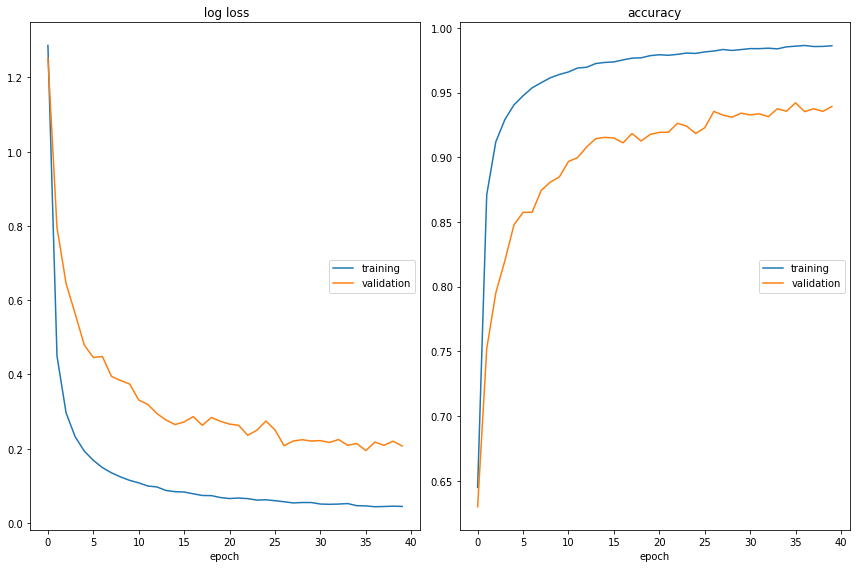

 log loss
	training         	 (min:    0.044, max:    1.286, cur:    0.045)
	validation       	 (min:    0.195, max:    1.253, cur:    0.207)
accuracy
	training         	 (min:    0.645, max:    0.986, cur:    0.986)
	validation       	 (min:    0.630, max:    0.942, cur:    0.939)


KeyboardInterrupt: 

In [11]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

train_model(model, optimizer, dataloaders, device, 128)

In [ ]:
# Eliminate overfitting:
# - Try CNN -> CTC loss https://www.cs.toronto.edu/~graves/icml_2006.pdf
# - try CNN for extraction a sequence of features and vanilla RNN to propagate information through this sequence.